In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import sys
import os
import json
import itertools
import umap
from colour import Color
from collections import Counter
sys.path.insert(1, "../")
sys.path.insert(1, "../utilities")

from group_analysis import do_kmeans_clustering, plot_clusters, log_and_scale, colour_list, display_group_kw_combis
from helpers import load_posts, load_toks, load_pos, get_top_n_toks
from clustering import reduce_features, make_elbow_plot, compare_binary_normed_feature_embeddings, mc_list, plot_bin_and_norm_clusters, plot_contingency_matrix, calculate_cluster_lrs

from language_change_methods.features import get_tok_counts, function_words, combine_counts, make_feature_matrix
from language_change_methods.utility_functions import basic_preprocessing, get_ngram_example, get_text_example_of_pos

from sklearn.cluster import KMeans, SpectralClustering, MeanShift, estimate_bandwidth, AgglomerativeClustering
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_predict
from sklearn import metrics

from nltk import ngrams as make_ngrams

from settings import TFES_FP as DB_FP, TFES_TOK_FP
GRAPH_DIR = "./Graphs"

In [2]:
%%time
all_posts = load_posts(DB_FP)

from helpers import flat_earth_boards, off_topic_boards as other_boards

fe_posts = all_posts.query("board_id in @flat_earth_boards")
ot_posts = all_posts.query("board_id in @other_boards")

toks = {int(x[0]): x[1] for x in load_toks(TFES_TOK_FP)}
toks = pd.Series(toks)
toks = toks[toks.index.isin(fe_posts.index)]

pos = {int(x[0]): x[1] for x in load_pos(TFES_TOK_FP)}
pos = pd.Series(pos)
pos = pos[pos.index.isin(fe_posts.index)]
pos = pos.loc[toks.index]

fe_posts = fe_posts.loc[toks.index]

Wall time: 31.3 s


In [3]:
with open("../data/user_metagroup.json") as group_file:
    meta_clusts = pd.Series(json.load(group_file))
    meta_clusts.index = meta_clusts.index.astype("float64")

In [4]:
# USERS_TO_INCLUDE = "100POSTS"
USERS_TO_INCLUDE = "TOP20"

In [5]:
post_lengths = toks.apply(len)
user_n_words = post_lengths.groupby(fe_posts["poster_id"]).sum()
posts_per_user = fe_posts.groupby("poster_id").size()

over_100 = posts_per_user[posts_per_user > 100]
print(f"{len(over_100)} with > 100 posts")

top_20 = posts_per_user.sort_values(ascending=False).head(20)
print(f"{len(over_100)} in the top 20")

if USERS_TO_INCLUDE == "100POSTS":
    curr_users = over_100
elif USERS_TO_INCLUDE == "TOP20":
    curr_users = top_20
    
user_n_words = user_n_words.loc[curr_users.index]
posts_per_user = posts_per_user.loc[curr_users.index]

curr_posts = fe_posts.query("poster_id in @curr_users.index")

# Get colour gradient
colour_gradient = list(Color("red").range_to(Color("blue"),len(curr_users)))
colour_gradient = pd.Series(colour_gradient, index=curr_users.sort_values(ascending=True).index)
colour_gradient = colour_gradient.loc[curr_users.index].apply(str)

101 with > 100 posts
101 in the top 20


# Create the user text chunks

In [6]:
merge_lists = lambda x: list(itertools.chain.from_iterable(x))

def get_chunks(u, tokens, chunk_size):
    for i in range(0, len(tokens)-chunk_size, chunk_size):
        yield u, tokens[i:i+chunk_size]

In [7]:
def make_tok_chonks(tokens, chunk_size):
    user_chunks = [[[user, chunk] for user, chunk in get_chunks(user, curr_toks, chunk_size)] for user, curr_toks in tokens.items()]
    user_chunks = merge_lists(user_chunks)
    user_chunks = pd.DataFrame(user_chunks, columns=["User", "Chunk"])
    return user_chunks

In [8]:
CHUNK_SIZE = 1000

In [9]:
%%time
user_toks = toks.groupby(curr_posts["poster_id"]).apply(merge_lists)
user_chunks = make_tok_chonks(user_toks, CHUNK_SIZE)

Wall time: 383 ms


In [10]:
%%time
user_pos = pos.groupby(curr_posts["poster_id"]).apply(merge_lists)
user_pos_chunks = make_tok_chonks(user_pos, CHUNK_SIZE)

Wall time: 415 ms


# Create the Different Feature Counts

#### BOW

In [11]:
%%time
# Get the counts
bow_counts = {i: get_tok_counts(post) for i, post in user_chunks["Chunk"].items()}
bow_counts = {i: {tok: count for tok, count in post.items() if tok not in function_words} for i, post in bow_counts.items()}
top_n = get_top_n_toks(bow_counts.values(), 5000)
bow_counts = {i: {tok: count for tok, count in post.items() if tok in top_n} for i, post in bow_counts.items()}
bow_counts = pd.Series(bow_counts)

Wall time: 19.6 s


#### Tfidf bow counts

In [12]:
%%time
# Credit for this cell: http://www.davidsbatista.net/blog/2018/02/28/TfidfVectorizer/
from sklearn.feature_extraction.text import TfidfVectorizer
# If you had counts instead of tokens, you'd use "TfidfTransformer"

def dummy_fun(doc):
    return doc

tfidf = TfidfVectorizer(
    analyzer='word',
    tokenizer=dummy_fun,
    preprocessor=dummy_fun,
    token_pattern=None)  


tfidf_matrix = tfidf.fit_transform(user_chunks["Chunk"])

Wall time: 783 ms


In [13]:
tfidf_feats = tfidf_matrix[:, np.isin(tfidf.get_feature_names(), top_n)].todense()

#### PoS Trigrams

In [14]:
pos_trigrams = pd.Series([make_ngrams(post, 3) for post in user_pos_chunks["Chunk"]], index=user_pos_chunks.index)
pos_trigrams = pos_trigrams.apply(lambda post: ["_".join(words) for words in post])

In [15]:
top_n = [x[0] for x in Counter(merge_lists(pos_trigrams)).most_common(1000)]
pos_tri_counts = pos_trigrams.apply(Counter).apply(lambda dic: {w: c for w, c in dic.items() if w in top_n})
pos_tri_counts = pd.Series(pos_tri_counts)

In [16]:
pos_tri_chunks = pd.DataFrame(index=user_pos_chunks.index)
pos_tri_chunks["User"] = user_pos_chunks["User"]
pos_tri_chunks["Chunk"] = pos_trigrams

In [17]:
# %%time
# pos_trigrams = pd.Series([make_ngrams(post, 3) for post in pos], index=pos.index)
# pos_trigrams = pos_trigrams.apply(lambda post: ["_".join(words) for words in post])
# u_pos_tri =  pos_trigrams.groupby(fe_posts["poster_id"]).apply(merge_lists)

# pos_tri_chunks = make_tok_chonks(u_pos_tri.loc[curr_users.index], CHUNK_SIZE)

In [18]:
# %%time
# top_n = [x[0] for x in Counter(merge_lists(pos_trigrams.loc[curr_posts.index])).most_common(1000)]
# pos_tri_counts = pos_tri_chunks["Chunk"].apply(Counter).apply(lambda dic: {w: c for w, c in dic.items() if w in top_n})
# pos_tri_counts = pd.Series(pos_tri_counts)

# Create the Feature Matrix

In [19]:
%%time
# Initialise feats to None
bin_feats = None
norm_feats = None

# Make the feature matrix
curr_feat_type = "pos_tri"
SCALE = True
APPLY_PCA = True

if curr_feat_type == "pos_tri":
    curr_counts = pos_tri_counts
    curr_chunks = pos_tri_chunks
elif curr_feat_type == "bow":
    curr_counts = bow_counts
    curr_chunks = user_chunks
elif curr_feat_type == "tfidf":
    curr_counts = bow_counts
    curr_chunks = user_chunks
    bin_feats = np.vectorize(lambda x: 1 if x > 0 else 0)(tfidf_feats)
    norm_feats = tfidf_feats
    
if bin_feats is None:
    curr_feats, curr_feat_names = make_feature_matrix(curr_counts.to_dict(), False)
    bin_feats = np.vectorize(lambda x: 1 if x > 0 else 0)(curr_feats)
    norm_feats = curr_feats / curr_chunks["Chunk"].apply(len).values[:,None]

Wall time: 1.01 s


#### Scaling

In [20]:
if SCALE:
    norm_feats = StandardScaler().fit_transform(norm_feats)

#### PCA reduction

In [21]:
%%time
from sklearn.decomposition import PCA
pca = PCA(.95)

if APPLY_PCA:
    norm_feats = pca.fit_transform(norm_feats)

Wall time: 806 ms


#### Make 2d embeddings

In [22]:
%%time
bin_embedding = reduce_features(bin_feats)
norm_embedding = reduce_features(norm_feats)

Wall time: 29.9 s


# Do the Clustering

In [23]:
%%time
# scaled = StandardScaler().fit_transform(bin_feats)
clst = KMeans(n_clusters=2, random_state=123)
bin_clusters = clst.fit_predict(bin_feats)

# scaled = StandardScaler().fit_transform(norm_feats)
clst = KMeans(n_clusters=2, random_state=123)
norm_clusters = clst.fit_predict(norm_feats)

Wall time: 529 ms


In [24]:
avg_silhouette_score = metrics.silhouette_score(bin_feats, bin_clusters)
print("Average silhoette score for Binary:\t", avg_silhouette_score, "\n")

avg_silhouette_score = metrics.silhouette_score(norm_feats, norm_clusters)
print("Average silhoette score for Normed:\t", avg_silhouette_score, "\n")

Average silhoette score for Binary:	 0.013200325757651428 

Average silhoette score for Normed:	 0.015375599857928014 



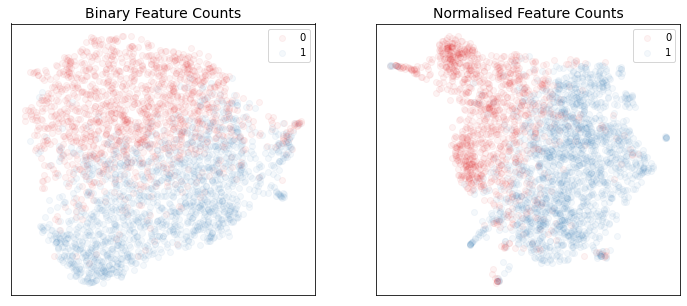

In [25]:
plot_bin_and_norm_clusters(bin_embedding, norm_embedding, 
                           bin_clusters, norm_clusters, 
                           alpha=0.05, out_fp=os.path.join(GRAPH_DIR, f"chunks_clusters_{curr_feat_type}.pdf"))

In [26]:
def chunk_cluster_info(f_name, X, chunk_users, clusters):
    print("------------------------------------------------------------------------------")
    print(f_name)
    print("------------------------------------------------------------------------------")

    sample_silhouette_values = metrics.silhouette_samples(X, clusters)
    
    for clust in set(clusters):
        num_chunks = len(clusters[clusters==clust])
        clust_users = chunk_users[clusters==clust]
    
        print("{0:10}\t{1:10}\t{2:10}\t{3:10.4f}".format(clust, 
                                              num_chunks, 
                                              len(clust_users.unique()), 
                                              sample_silhouette_values[clusters == clust].mean()))

In [27]:
for f_name, X, clusters in zip(["Binary", "Normalised"], [bin_feats, norm_feats], [bin_clusters, norm_clusters]):
    chunk_cluster_info(f_name, X, curr_chunks["User"], clusters)


------------------------------------------------------------------------------
Binary
------------------------------------------------------------------------------
         0	      1394	        19	    0.0017
         1	      1529	        20	    0.0237
------------------------------------------------------------------------------
Normalised
------------------------------------------------------------------------------
         0	      1177	        20	    0.0379
         1	      1746	        20	    0.0002


## Run with 20 clusters too

In [28]:
%%time
# scaled = StandardScaler().fit_transform(bin_feats)
clst = KMeans(n_clusters=20, random_state=123)
bin_clusters_20 = clst.fit_predict(bin_feats)

# scaled = StandardScaler().fit_transform(norm_feats)
clst = KMeans(n_clusters=20, random_state=123)
norm_clusters_20 = clst.fit_predict(norm_feats)

Wall time: 2.91 s


In [29]:
avg_silhouette_score = metrics.silhouette_score(bin_feats, bin_clusters_20)
print("Average silhoette score for Binary:\t", avg_silhouette_score, "\n")

avg_silhouette_score = metrics.silhouette_score(norm_feats, norm_clusters_20)
print("Average silhoette score for Normed:\t", avg_silhouette_score, "\n")

Average silhoette score for Binary:	 0.0004678074409094327 

Average silhoette score for Normed:	 -0.0009618391057673093 



In [30]:
for f_name, X, clusters in zip(["Binary", "Normalised"], [bin_feats, norm_feats], [bin_clusters_20, norm_clusters_20]):
    chunk_cluster_info(f_name, X, curr_chunks["User"], clusters)

------------------------------------------------------------------------------
Binary
------------------------------------------------------------------------------
         0	        63	         7	    0.0323
         1	       151	        11	    0.0013
         2	       249	        15	    0.0000
         3	        62	         7	   -0.0019
         4	       113	         6	    0.0230
         5	       209	        10	   -0.0051
         6	        93	         8	    0.0006
         7	        13	         6	   -0.0050
         8	       176	        12	   -0.0072
         9	       174	         9	   -0.0025
        10	       137	         8	    0.0050
        11	       185	        13	   -0.0028
        12	       112	        10	   -0.0030
        13	       239	        10	    0.0003
        14	       174	        10	    0.0034
        15	       169	        16	   -0.0083
        16	       165	        17	    0.0072
        17	       127	         9	   -0.0007
        18	       131	        11	   -0.0072

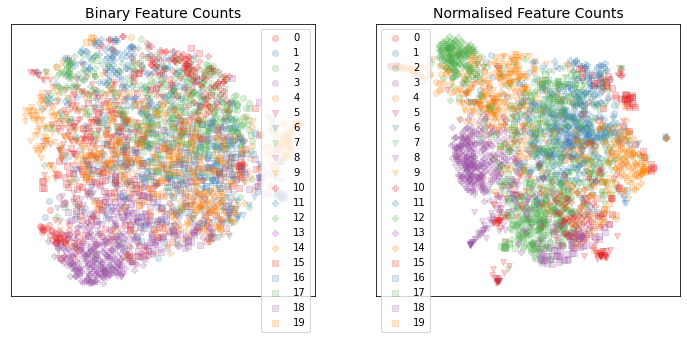

In [31]:
plot_bin_and_norm_clusters(bin_embedding, norm_embedding, bin_clusters_20, norm_clusters_20, alpha=0.2)

# Find Suitable Number of Clusters

In [32]:
%%time
# make_elbow_plot(bin_feats, start=1, end=100, step=20, scaler=None)

Wall time: 0 ns


In [33]:
%%time
# make_elbow_plot(scaled, start=1, end=100, step=20, scaler=None)

Wall time: 0 ns


# Analyse Spread Across Users

In [34]:
bin_contingency = pd.crosstab(curr_chunks["User"].values, [bin_clusters], rownames=["User"], colnames=["Cluster"])

In [35]:
print(f"{'Cluster':10}\t{'Num Users':10}\t{'Num Chunks':10}\t{'Chunks/Users':10}")
for clust in range(len(set(bin_clusters))):
    n_users = len(curr_chunks["User"][bin_clusters==clust].unique())
    clust_size = len(bin_clusters[bin_clusters==clust])
    print(f"{clust:10}\t{n_users:10}\t{clust_size:10}\t{clust_size/n_users:10.2f}")

Cluster   	Num Users 	Num Chunks	Chunks/Users
         0	        19	      1394	     73.37
         1	        20	      1529	     76.45


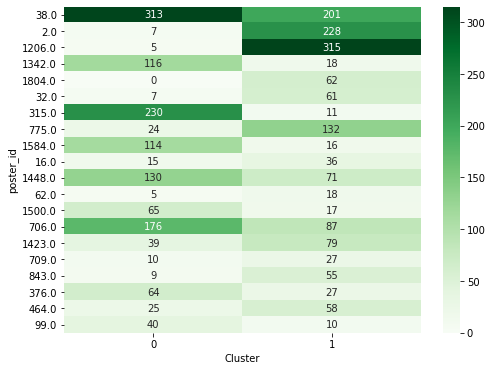

In [36]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(bin_contingency.loc[posts_per_user.sort_values(ascending=False).head(20).index], annot=True, ax=ax, fmt='g', cmap="Greens")
fig.savefig(os.path.join(GRAPH_DIR, f"chunk_contingency_2_{curr_feat_type}.pdf"))
plt.show()

In [37]:
norm_contingency = pd.crosstab(curr_chunks["User"].values, [norm_clusters], rownames=["User"], colnames=["Cluster"])

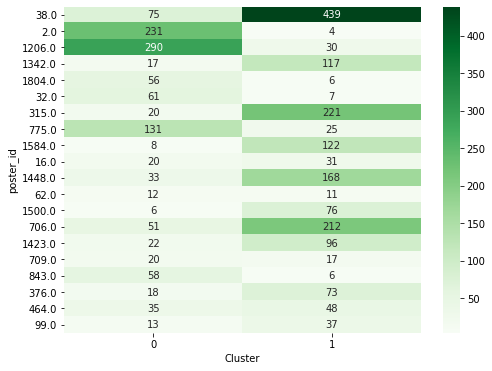

In [38]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(norm_contingency.loc[posts_per_user.sort_values(ascending=False).head(20).index], annot=True, ax=ax, fmt='g', cmap="Greens")
plt.show()

In [43]:
# The predicted cluster for each user.
norm_contingency.idxmax(axis=1).sort_values()

User
2.0       0
1206.0    0
843.0     0
775.0     0
709.0     0
1804.0    0
62.0      0
32.0      0
315.0     1
376.0     1
464.0     1
1584.0    1
38.0      1
16.0      1
1342.0    1
1423.0    1
1448.0    1
1500.0    1
99.0      1
706.0     1
dtype: int64

In [40]:
# The percentage of a user's chunks that go in their larger cluster
# See it as the probability of being in the correct cluster
correct_cluster_prob = norm_contingency.apply(lambda x: x[x.idxmax()], axis=1) / norm_contingency.sum(axis=1)
correct_cluster_prob.sort_values(ascending=False)

User
2.0       0.982979
1584.0    0.938462
1500.0    0.926829
315.0     0.917012
1206.0    0.906250
843.0     0.906250
1804.0    0.903226
32.0      0.897059
1342.0    0.873134
38.0      0.854086
775.0     0.839744
1448.0    0.835821
1423.0    0.813559
706.0     0.806084
376.0     0.802198
99.0      0.740000
16.0      0.607843
464.0     0.578313
709.0     0.540541
62.0      0.521739
dtype: float64

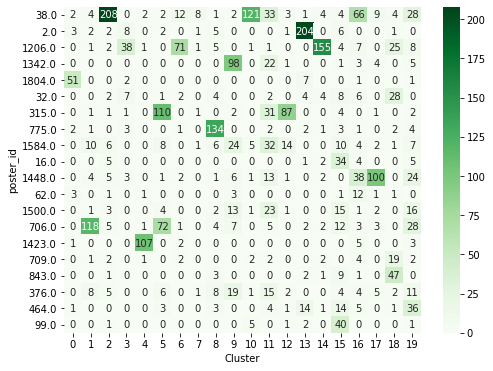

In [41]:
# For 20 clusters
bin_contingency_20 = pd.crosstab(curr_chunks["User"].values, [bin_clusters_20], rownames=["User"], colnames=["Cluster"])

fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(bin_contingency_20.loc[posts_per_user.sort_values(ascending=False).head(20).index], annot=True, ax=ax, fmt='g', cmap="Greens")

fig.savefig(os.path.join(GRAPH_DIR, f"chunk_contingency_20_{curr_feat_type}.pdf"))

plt.show()

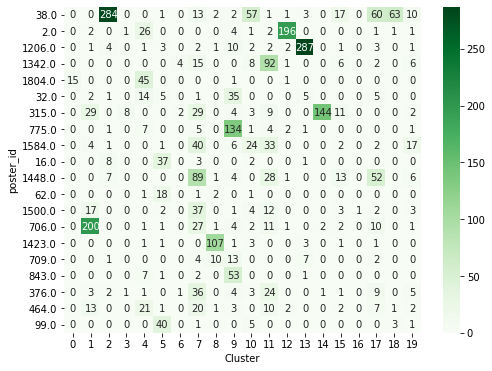

In [42]:
# For 20 clusters
norm_contingency_20 = pd.crosstab(curr_chunks["User"].values, [norm_clusters_20], rownames=["User"], colnames=["Cluster"])

fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(norm_contingency_20.loc[posts_per_user.sort_values(ascending=False).head(20).index], annot=True, ax=ax, fmt='g', cmap="Greens")
plt.show()

# Get Some Keywords Between Clusters

In [ ]:
%%time
lr = lambda x, y: np.log2(x / y)
# curr_counts = bow_counts
clusters = bin_clusters

clust_counts = curr_counts.groupby(clusters).apply(combine_counts).apply(lambda x: x[0])
clust_n_words = {clust: len(clusters[clusters==clust]) * CHUNK_SIZE for clust in range(len(set(clusters)))}

In [ ]:
%%time
for clust, counts in clust_counts.items():
    other_counts = combine_counts(curr_counts[clusters!=clust])[0]
    other_nwords = len(clusters[clusters!=clust]) * CHUNK_SIZE
    lrs = calculate_cluster_lrs(counts, other_counts, clust_n_words[clust], other_nwords)
    lrs = {w: l for w, l in lrs.items() if counts[w] > 100}
    lrs = pd.Series(lrs).sort_values(ascending=False)
    t10_lr = lrs.head(20)
    b10_lr = lrs.tail(20)
    
    print(clust)
    print("-------------------------------------------------------------------------------------")
    for (w1, lr1), (w2, lr2) in zip(t10_lr.items(), b10_lr.items()):
        print(f"{w1:20}\t{lr1:10.2f}\t|\t{w2:20}\t{lr2:10.2f}")
    print("-------------------------------------------------------------------------------------")

In [ ]:
%%time
lr = lambda x, y: np.log2(x / y)
counts_for_kw = bow_counts.loc[curr_counts.index]
clusters = bin_clusters

clust_counts = counts_for_kw.groupby(clusters).apply(combine_counts).apply(lambda x: x[0])
clust_n_words = {clust: len(clusters[clusters==clust]) * CHUNK_SIZE for clust in range(len(set(clusters)))}

for clust, counts in clust_counts.items():
    other_counts = combine_counts(counts_for_kw[clusters!=clust])[0]
    other_nwords = len(clusters[clusters!=clust]) * CHUNK_SIZE
    lrs = calculate_cluster_lrs(counts, other_counts, clust_n_words[clust], other_nwords)
    lrs = {w: l for w, l in lrs.items() if counts[w] > 100}
    lrs = pd.Series(lrs).sort_values(ascending=False)
    t10_lr = lrs.head(20)
    b10_lr = lrs.tail(20)
    
    print(clust)
    print("-------------------------------------------------------------------------------------")
    for (w1, lr1), (w2, lr2) in zip(t10_lr.items(), b10_lr.items()):
        print(f"{w1:20}\t{lr1:10.2f}\t|\t{w2:20}\t{lr2:10.2f}")
    print("-------------------------------------------------------------------------------------")

In [ ]:
%%time
lr = lambda x, y: np.log2(x / y)
# curr_counts = bow_counts
clusters = bin_clusters_20

clust_counts = curr_counts.groupby(clusters).apply(combine_counts).apply(lambda x: x[0])
clust_n_words = {clust: len(clusters[clusters==clust]) * CHUNK_SIZE for clust in range(len(set(clusters)))}

In [ ]:
%%time
for clust, counts in clust_counts.items():
    other_counts = combine_counts(curr_counts[clusters!=clust])[0]
    other_nwords = len(clusters[clusters!=clust]) * CHUNK_SIZE
    lrs = calculate_cluster_lrs(counts, other_counts, clust_n_words[clust], other_nwords)
    lrs = {w: l for w, l in lrs.items() if counts[w] > 100}
    lrs = pd.Series(lrs).sort_values(ascending=False)
    t10_lr = lrs.head(20)
    b10_lr = lrs.tail(20)
    
    print(clust)
    print("-------------------------------------------------------------------------------------")
    for (w1, lr1), (w2, lr2) in zip(t10_lr.items(), b10_lr.items()):
        print(f"{w1:20}\t{lr1:10.2f}\t|\t{w2:20}\t{lr2:10.2f}")
    print("-------------------------------------------------------------------------------------")

In [ ]:
%%time
lr = lambda x, y: np.log2(x / y)
clusters = bin_clusters_20
counts_for_kw = bow_counts.loc[curr_counts.index]

clust_counts = counts_for_kw.groupby(clusters).apply(combine_counts).apply(lambda x: x[0])
clust_n_words = {clust: len(clusters[clusters==clust]) * CHUNK_SIZE for clust in range(len(set(clusters)))}

for clust, counts in clust_counts.items():
    other_counts = combine_counts(counts_for_kw[clusters!=clust])[0]
    other_nwords = len(clusters[clusters!=clust]) * CHUNK_SIZE
    lrs = calculate_cluster_lrs(counts, other_counts, clust_n_words[clust], other_nwords)
    lrs = {w: l for w, l in lrs.items() if counts[w] > 100}
    lrs = pd.Series(lrs).sort_values(ascending=False)
    t10_lr = lrs.head(20)
    b10_lr = lrs.tail(20)
    
    print(clust)
    print("-------------------------------------------------------------------------------------")
    for (w1, lr1), (w2, lr2) in zip(t10_lr.items(), b10_lr.items()):
        print(f"{w1:20}\t{lr1:10.2f}\t|\t{w2:20}\t{lr2:10.2f}")
    print("-------------------------------------------------------------------------------------")

In [ ]:
%%time
get_text_example_of_pos(["NOUN", "SCONJ", "PROPN"], 
                        pos.loc[curr_posts.index], 
                        toks.loc[curr_posts.index], 
                        doc_labels=curr_posts["poster_id"].values)